In [1]:
from itertools import islice

import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import pandas as pd
import numpy as np

/Users/jhuang/Workspace/repos/hsi/venv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [6]:
df = pd.read_csv("./HSI.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [59]:
df.index = pd.to_datetime(df.index)

# Create a date range from the minimum to maximum date in the index
date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame with the date range to fill in missing dates with NaN
df = df.reindex(date_range).sort_index()

In [ ]:
feat_dynamic_real=["Open", "High", "Low", "Adj Close"]
dataset = PandasDataset(df.ffill(), target="Close", freq="D",
                       feat_dynamic_real=feat_dynamic_real)

prediction_length=5
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-36)
test_data = test_gen.generate_instances(prediction_length=prediction_length, windows=3)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=prediction_length, freq="D", trainer_kwargs={"max_epochs": 30},
    num_feat_dynamic_real=len(feat_dynamic_real)
).train(training_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jhuang/Workspace/repos/hsi/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                        | Out sizes  
----------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 26.5 K | [[1, 1], [1, 1], [1, 1097, 8], [1, 1097], [1, 1097], [1, 5, 8]] | [1, 100, 5]
----------------------------------------------------------------------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Training: |                                                                                             | 0/? …

Epoch 0, global step 50: 'train_loss' reached 9.87318 (best 9.87318), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.03635 (best 8.03635), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.62329 (best 7.62329), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.48207 (best 7.48207), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_18/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.42662 (best 7.42662), saving model to '/Users/jhuang/Workspace/repos/hsi/lightning_logs/version_18/checkpoints/epoch=4-step=250.ckpt' as top 1


In [97]:
forecasts = list(model.predict(test_data.input))

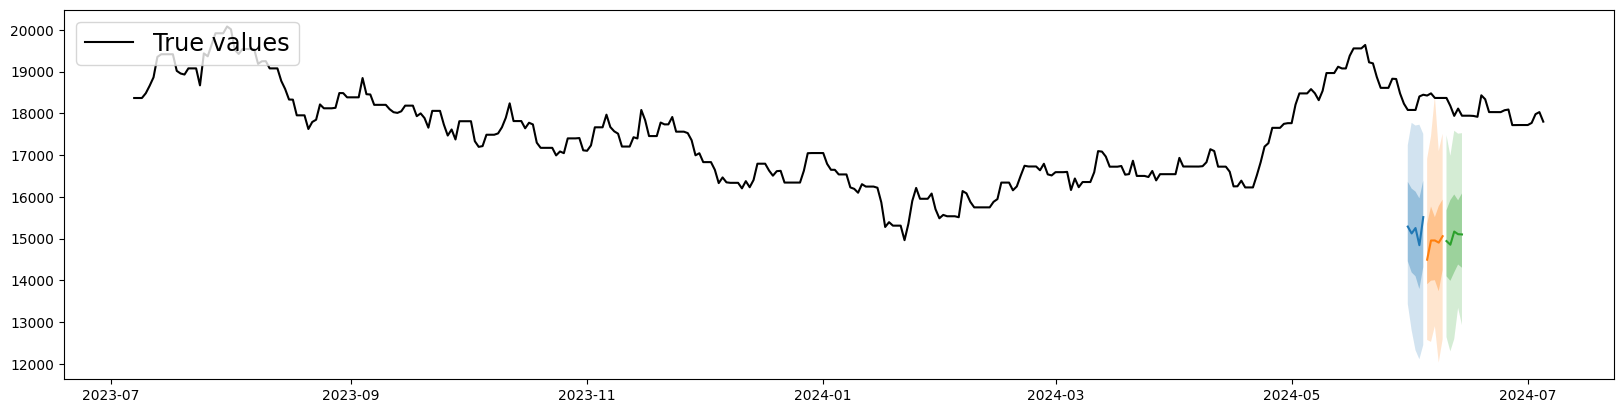

In [112]:
plt.figure().set_figwidth(20)
# Plot predictions
plt.plot(df.Close.ffill(), color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()